# Training 10 Models and Scoring
## Load data in tidy format

In [9]:
import pandas as pd

df = pd.read_csv('../data/ellipse_raw_rater_scores_tidy.csv', index_col=0)
df=df[df['variable']=='Phraseology']
df = df[['Filename', 'Text', 'criterion', 'Rater']]
df.columns = ['filename', 'text', 'labels', 'rater']
unique_filenames = df['filename'].unique()
df['labels']=df['labels'].astype(float)
df.head()

,filename,text,labels,rater
71120,2021000071.txt,"To the Principal,\r\n\r\nI think that policy 1...",4.0,rater_1
71121,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",3.0,rater_1
71122,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",2.0,rater_1
71123,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,3.0,rater_1
71124,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,3.0,rater_1


## Descriptive Stats

In [10]:
# Calculate filenames per rater
filenames_per_rater = df.groupby('rater')['filename'].nunique()

# Calculate statistics
mean_filenames = filenames_per_rater.mean()
std_filenames = filenames_per_rater.std()
min_filenames = filenames_per_rater.min()
max_filenames = filenames_per_rater.max()

# Print results
print("Filename Count per Rater:")
print(filenames_per_rater)
print("\nStatistics:")
print(f"Mean: {mean_filenames}")
print(f"Standard Deviation: {std_filenames}")
print(f"Minimum: {min_filenames}")
print(f"Maximum: {max_filenames}")

Filename Count per Rater:
rater
rater_1      860
rater_10     782
rater_11    1370
rater_12    1222
rater_13     890
rater_14      31
rater_15     991
rater_16     447
rater_17     119
rater_18    1062
rater_19    1043
rater_2     1609
rater_20      75
rater_21     359
rater_22     241
rater_23     778
rater_24     260
rater_25      27
rater_26     200
rater_27     587
rater_3      331
rater_4      609
rater_5      226
rater_6     1340
rater_7     1213
rater_8      360
rater_9      748
Name: filename, dtype: int64

Statistics:
Mean: 658.5185185185185
Standard Deviation: 461.8064338401776
Minimum: 27
Maximum: 1609


In [11]:
print(df.columns)
df = df[df['labels']!=0]
df['filename'].nunique()
df

Index(['filename', 'text', 'labels', 'rater'], dtype='object')


,filename,text,labels,rater
71120,2021000071.txt,"To the Principal,\r\n\r\nI think that policy 1...",4.0,rater_1
71121,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",3.0,rater_1
71122,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",2.0,rater_1
71123,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,3.0,rater_1
71124,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,3.0,rater_1
...,...,...,...,...
88895,AAAUUP138190002317322139_OR.txt,We have to work to survive. Employers give us ...,4.0,rater_23
88896,AAAUUP138190002408242136_OR.txt,Studies show that giving students holiday brea...,5.0,rater_23
88897,AAAUUP138190002420682110_OR.txt,Introduction:\r\n\r\nAuthor Ralph Waldo Emerso...,3.0,rater_23
88898,AAAUUP138190002783782122_OR.txt,"Technology, has been discuess by many knowledg...",2.0,rater_23


## Train Models

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
import random
from tqdm import tqdm

In [13]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [14]:
MODEL_NAME = "answerdotai/ModernBERT-base"

In [15]:
# Prepare datasets
def prepare_dataset_for_training(df_subset):
    """Prepare dataset for training"""
    # Split data
    train_df, eval_df = train_test_split(
        df_subset, 
        test_size=0.2, 
        random_state=42,
        stratify=df_subset['labels']
    )
    
    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    
    # Convert to datasets
    train_dataset = Dataset.from_pandas(train_df)
    eval_dataset = Dataset.from_pandas(eval_df)
    
    # Tokenize
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
    
    return tokenized_train, tokenized_eval, tokenizer

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics_regression(eval_pred):
    """Compute MSE for regression tasks"""
    predictions, labels = eval_pred
    
    # Predictions are already continuous values
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(labels - predictions))  # Mean Absolute Error
    
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae
    }

In [17]:
# Function to predict on new data
def predict_with_model(model, tokenizer, texts):
    """Make predictions on a list of texts"""
    predictions = []
    batch_size = 16
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        model.to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            # For regression, outputs.logits is already the predicted value
            batch_preds = outputs.logits.flatten()
            predictions.extend(batch_preds.cpu().numpy())
    
    return predictions

In [18]:
filenames = df['filename'].unique()
def split_random_groups_numpy(filenames, num_groups=10):
    """
    Split filenames into random groups using NumPy
    """
    # Convert to numpy array and shuffle
    arr = np.array(filenames)
    np.random.shuffle(arr)
    
    # Split into groups
    groups = np.array_split(arr, num_groups)
    
    # Convert back to lists
    return [group.tolist() for group in groups]

# Example usage
test_groups = split_random_groups_numpy(filenames, 10)

len(test_groups)

10

In [22]:
# Main training and prediction loop
all_predictions_dfs = []
mse_list = []

for model_idx in tqdm(range(1, 11), desc="Training models"):
    print(f"\n{'='*60}")
    print(f"Training Model {model_idx}/10")
    print(f"{'='*60}")
    test_filenames = test_groups[model_idx-1]
    # Set seed for reproducibility (different for each model)
    set_seed(model_idx * 42)
    
    # Create train and test splits
    test_mask = df['filename'].isin(test_filenames)
    train_mask = ~test_mask
    
    train_df = df[train_mask].copy()
    test_df = df[test_mask].copy()
    
    print(f"Model {model_idx}:")
    print(f"  Training files: {len(filenames) - len(test_filenames)}")
    print(f"  Training samples: {len(train_df)}")
    print(f"  Test files: {len(test_filenames)}")
    print(f"  Test samples: {len(test_df)}")
    
    # Prepare training dataset
    train_dataset, eval_dataset, tokenizer = prepare_dataset_for_training(train_df)
    
    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=1, 
    )
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./modernbert_model_{model_idx}",
        overwrite_output_dir=True,
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=100,
        weight_decay=1e-6,
        learning_rate=8e-5,
        logging_dir=f"./logs_{model_idx}",
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="mse",
        greater_is_better=False,
        save_total_limit=1,
        seed=model_idx * 42,
        report_to="none"  # Disable wandb/tensorboard if not needed
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_regression,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate on validation set
    eval_result = trainer.evaluate()
    print(f"  Validation Accuracy: {eval_result.get('eval_accuracy', 0):.4f}")
    
    # Make predictions on held-out data
    print("  Making predictions on held-out filenames...")
    
    # Get texts from test set
    test_texts = test_df['text'].tolist()
    test_labels = test_df['labels'].tolist()
    
    # Predict
    test_predictions = predict_with_model(model, tokenizer, test_texts)

    print(f'MSE on held-out test set: {mean_squared_error(test_labels, test_predictions)}')
    mse_list.append(mean_squared_error(test_labels, test_predictions))
    # Create prediction dataframe
    pred_df = test_df.copy()
    pred_df['labels'] = test_predictions  # Replace actual labels with predictions
    pred_df['rater'] = f'model_{model_idx}'
    
    # Combine train and test predictions for this model
    all_pred_df = pred_df
    
    # Sort by filename to maintain order
    all_pred_df = all_pred_df.sort_values('filename').reset_index(drop=True)
    
    # Add to list
    all_predictions_dfs.append(all_pred_df)
    
    # Save model
    model.save_pretrained(f"./saved_model_{model_idx}")
    tokenizer.save_pretrained(f"./saved_model_{model_idx}")
    
    print(f"  Saved model {model_idx}")
    print(f"  Total predictions made: {len(all_pred_df)}")

print(f"\n{'='*60}")
print("All models trained and predictions generated!")
print(f"{'='*60}")

Training models:   0%|          | 0/10 [00:00<?, ?it/s]


Training Model 1/10
Model 1:
  Training files: 7989
  Training samples: 15969
  Test files: 888
  Test samples: 1775


Map:   0%|          | 0/12775 [00:00<?, ? examples/s]

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_94/1826919071.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.497700,0.425162,0.425162,0.652044,0.733588
2,0.282300,0.417237,0.417237,0.645939,0.758949


  Validation Accuracy: 0.0000
  Making predictions on held-out filenames...
MSE on held-out test set: 0.3988018107395888


Training models:  10%|█         | 1/10 [20:14<3:02:09, 1214.41s/it]

  Saved model 1
  Total predictions made: 1775

Training Model 2/10
Model 2:
  Training files: 7989
  Training samples: 15969
  Test files: 888
  Test samples: 1775


Map:   0%|          | 0/12775 [00:00<?, ? examples/s]

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_94/1826919071.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.392500,0.414057,0.414057,0.643473,0.790447
2,0.331000,0.401080,0.401080,0.633309,0.777214


  Validation Accuracy: 0.0000
  Making predictions on held-out filenames...
MSE on held-out test set: 0.3996864132840256


Training models:  20%|██        | 2/10 [37:54<2:29:49, 1123.66s/it]

  Saved model 2
  Total predictions made: 1775

Training Model 3/10
Model 3:
  Training files: 7989
  Training samples: 15968
  Test files: 888
  Test samples: 1776


Map:   0%|          | 0/12774 [00:00<?, ? examples/s]

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_94/1826919071.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.552600,0.520843,0.520843,0.721694,0.742003
2,0.432600,0.452267,0.452267,0.672508,0.745216


  Validation Accuracy: 0.0000
  Making predictions on held-out filenames...
MSE on held-out test set: 0.4446254395019676


Training models:  30%|███       | 3/10 [55:27<2:07:20, 1091.52s/it]

  Saved model 3
  Total predictions made: 1776

Training Model 4/10
Model 4:
  Training files: 7989
  Training samples: 15969
  Test files: 888
  Test samples: 1775


Map:   0%|          | 0/12775 [00:00<?, ? examples/s]

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_94/1826919071.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.299200,0.475271,0.475271,0.689399,0.800733


  Validation Accuracy: 0.0000
  Making predictions on held-out filenames...
MSE on held-out test set: 0.3801430459730207


Training models:  40%|████      | 4/10 [1:13:04<1:47:47, 1077.89s/it]

  Saved model 4
  Total predictions made: 1775

Training Model 5/10
Model 5:
  Training files: 7989
  Training samples: 15970
  Test files: 888
  Test samples: 1774


Map:   0%|          | 0/12776 [00:00<?, ? examples/s]

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_94/1826919071.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.399000,0.474543,0.474543,0.688871,0.776855


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Check output

In [23]:
print(mse_list)

# Combine all predictions into one dataframe
final_df = pd.concat(all_predictions_dfs, ignore_index=True)

# Sort by filename and rater for better organization
final_df = final_df.sort_values(['filename', 'rater']).reset_index(drop=True)

# Save to CSV
final_df.drop_duplicates().to_csv('../data/all_model_predictions1.csv', index=False)

print(f"\nFinal dataframe shape: {final_df.shape}")
print(f"Number of unique filenames: {final_df['filename'].nunique()}")
print(f"Number of raters: {final_df['rater'].nunique()}")

# Display sample of the final dataframe
print("\nSample of final predictions dataframe:")
print(final_df.drop_duplicates().head(10))

[0.3988018107395888, 0.3996864132840256, 0.4446254395019676, 0.3801430459730207, 0.4043201881015549, 0.38125827191194256, 0.40791846895121603, 0.4249178233803022, 0.41876848521325466, 0.4277511767301555]

Final dataframe shape: (17744, 4)
Number of unique filenames: 8877
Number of raters: 10

Sample of final predictions dataframe:
          filename                                               text  \
0   2021000071.txt  To the Principal,\r\n\r\nI think that policy 1...   
2   2021000501.txt  Dear, TEACHER_NAME\r\n\r\nI think phone policy...   
4   2021000535.txt  Dear, Principal\r\n\r\nIn my opinion, I think ...   
6   2021000667.txt  PHONES\r\n\r\nDear principal students should h...   
8   2021000683.txt  phones\r\n\r\ni think phones should be allowed...   
10  2021000705.txt  Do you really think students need cell phones ...   
12  2021000748.txt  Should students be allowed to have cell phones...   
14  2021000756.txt  dear TEACHER_NAME i think the you should let s...   
16  202100

In [24]:
print(final_df.shape)
print(final_df.drop_duplicates().shape)

(17744, 4)
(8923, 4)


In [25]:
final_df = final_df.drop_duplicates(subset=['filename', 'text', 'rater'], keep='first')

<Axes: >

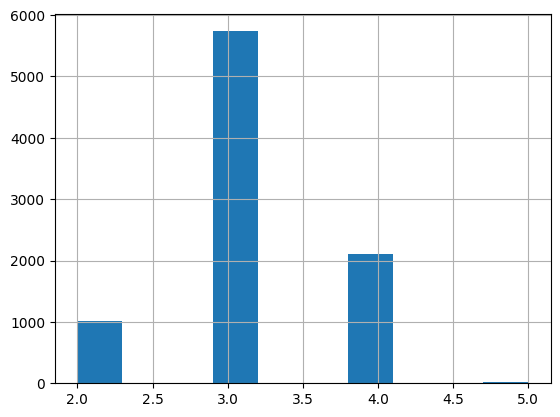

In [26]:
final_df['labels'] = final_df['labels'].round().astype(int)
final_df.labels.hist()

In [27]:
export_df = pd.concat([final_df, df])
export_df.to_csv('../data/df_with_model_predictions1.csv')

In [6]:
import pandas as pd

mses = pd.Series([0.3988018107395888, 0.3996864132840256, 0.4446254395019676, 0.3801430459730207, 0.4043201881015549, 0.38125827191194256, 0.40791846895121603, 0.4249178233803022, 0.41876848521325466, 0.4277511767301555])

print(mses.max())

0.4446254395019676
